In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import  RandomForestRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree
RSEED = 42


In [326]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [327]:
df_train["STA"] = df_train['STA'].str.replace(".", ":")
df_train["STA"] = pd.to_datetime(df_train["STA"])
df_train["STD"] = pd.to_datetime(df_train["STD"])
df_train["DATOP"] = pd.to_datetime(df_train["DATOP"], format='%Y-%m-%d')

df_train["airline_code"] = df_train['FLTID'].str.split(' ').str[0]
df_train["flt_num"] = df_train['FLTID'].str.split(' ').str[1]
df_train["AC_airline_code"] = df_train['AC'].str.split(' ').str[0]
df_train["AC_num"] = df_train['AC'].str.split(' ').str[1]
df_train["STD_year"] = df_train['STD'].dt.year
df_train["STD_month"] = df_train['STD'].dt.month
df_train["STD_day"] = df_train['STD'].dt.day_of_week
df_train["STD_hour"] = df_train['STD'].dt.hour
df_train["STA_hour"] = df_train['STA'].dt.hour
df_train["DURATION"] = (df_train.STA - df_train.STD) / timedelta(minutes = 1)
df_train["plain"] = df_train['AC'].str.split(' ').str[1].str[:3]
datop_dep_counts = df_train.groupby(['DATOP', 'DEPSTN']).size()# Group by DATOP and DEPSTN and calculate the occurrences
df_train['DATOP_DEP_count'] = df_train.set_index(['DATOP', 'DEPSTN']).index.map(datop_dep_counts)# Map the counts to a new column in df_train

datop_arr_counts = df_train.groupby(['DATOP', 'ARRSTN']).size()# Group by DATOP and ARRST and calculate the occurrences
df_train['DATOP_ARR_count'] = df_train.set_index(['DATOP', 'ARRSTN']).index.map(datop_arr_counts)# Map the counts to a new column in df_train

# Define a function to categorize hours
def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'noon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply the function to categorize STD_hour and STA_hour
df_train['STD_hour_category'] = df_train['STD_hour'].apply(categorize_hour)


# hot-encode daytime one-hot encoding
daytime = pd.get_dummies(df_train['STD_hour_category'], prefix='daytime', dtype = int)# not sure about dropping first

# hot-encode status
status = pd.get_dummies(df_train['STATUS'], prefix='status', dtype = int) # not sure about dropping first
# hot-encode airports_dep
airports_dep = pd.get_dummies(df_train['DEPSTN'], prefix='DEPSTN', dtype = int) # not sure about dropping first
# hot-encode airports_arrv
airports_arrv = pd.get_dummies(df_train['ARRSTN'], prefix='ARRSTN', dtype = int) # not sure about dropping first

df_train = pd.concat([df_train, daytime,status, airports_dep, airports_arrv], axis=1)

df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,ARRSTN_TRN,ARRSTN_TUN,ARRSTN_VCE,ARRSTN_VIE,ARRSTN_VKO,ARRSTN_VNO,ARRSTN_VOG,ARRSTN_VRN,ARRSTN_YUL,ARRSTN_ZRH
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,0,1,0,0,0,0,0,0,0,0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,0,1,0,0,0,0,0,0,0,0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,...,0,0,0,0,0,0,0,0,0,0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,...,0,0,0,0,0,0,0,0,0,0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,...,0,0,0,0,0,0,0,0,0,0


In [328]:
# our dataframe contains of 10 columns and almost all of them are categorical.
# besides each of the categorical features contains of many unique values.
# we can not convert them into meaningful numbers, so we will use one hot encoding
# we need to create a dataframe which will contain only relevant features, otherwise the amouunt of features will be too high. 
# Therefore we will start with few columns, look how the model going to perform and than add more columns.

#it seems, that the most relevant columns are:

# 1. Round

# -month: since the country is very touristic, in certain months the number of flights is much higher than in others.
     # easy to implement, since no hot encoding needed
# - year: it seems that the delays incresed during the years 
     # easy to implement, since no hot encoding needed
# - day
    # easy to implement, since no hot encoding needed
# - hour of departure and arrival: it seems that the delays are higher during the day than during the night. 
     # easy to implement, since no hot encoding needed
# - duraion of the flight

# 2. Round

# -status: here the categories DEL and SCH always provide y = 0 ==> hot-encode them
# -airports: it seems that the airport show a very different delay behaviour. There are a alot of them, and we still have to encode them.
         # it might be interesting if there is an influence on the delay is identical for the same airport, regardless if it is the departure or arrival airport, would reduce the number of features




# maybe we should include the number of flights per day, since it might be that the more flights are scheduled, the higher the delay is.
     # additionally, it should be calculated for each airport

# -daytime: as exprected during the noon the delays are much higher than during the night.
         # next, we should check if there is the difference between daytime of departure and arrival
         # include later, since easier to work with hour of departure and arrival, just 2 categories


In [329]:
df_train.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target',
       ...
       'ARRSTN_TRN', 'ARRSTN_TUN', 'ARRSTN_VCE', 'ARRSTN_VIE', 'ARRSTN_VKO',
       'ARRSTN_VNO', 'ARRSTN_VOG', 'ARRSTN_VRN', 'ARRSTN_YUL', 'ARRSTN_ZRH'],
      dtype='object', length=293)

In [330]:
y = df_train['target']

X = df_train[['STD_year', 'STD_month', 'STD_day', 'STD_hour', 'STA_hour', 'DURATION']]#no daytime, no STATUS
#X = df_train[['STD_year', 'STD_month', 'STD_day', 'STD_hour', 'STA_hour', 'DURATION', 'status_ATA', 'status_DEL','status_DEP', 'status_RTR', 'status_SCH']]#no daytime
#X = df_train[['STD_year', 'STD_month', 'STD_day', 'DURATION', 'daytime_morning','daytime_noon', 'daytime_evening','daytime_night']]#no hours, no STATUS

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED) # no stratify, since the target is not categorical

In [332]:
#y_train = np.log1p(y_train['target']) # should be done after splitting, we want influence the test set

In [333]:
#get to know if some features are skewd and require transformation
#sns.pairplot(X_train, diag_kind='kde')

In [334]:
# maybe try different scalers (minmax, standard or roubst)
#shouldnt be used for decision trees, since thean the columns are gone and we wouldnt be able to to the feature importance analysis and to look at the decision tree
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [335]:
#model_dtc = DecisionTreeRegressor(random_state=RSEED, max_depth=20)
model_dtc = RandomForestRegressor(random_state=RSEED, n_estimators=100, max_depth=20, max_features='sqrt')
model_dtc.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', random_state=42)

In [336]:
pred_test_dtc = model_dtc.predict(X_test)
pred_train_dtc = model_dtc.predict(X_train)

#pred_test_dtc = np.expm1(model_dtc.predict(X_test))
#pred_train_dtc = np.expm1(model_dtc.predict(X_train))


In [337]:
def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """Calculate and print out RMSE and R2 for train and test data

    Args:
        y_train (array): true values of y_train
        y_pred_train (array): predicted values of model for y_train
        y_test (array): true values of y_test
        y_pred_test (array): predicted values of model for y_test
    """

    print("Metrics on training data") 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))
    r2 = r2_score(y_train,y_pred_train)
    mae = mean_absolute_error(y_train,y_pred_train)
    print("MAE: ", round(mae,3))
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)
    
    # Calculate metric
    print("Metrics on test data")  
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))
    r2 = r2_score(y_test,y_pred_test)
    mae = mean_absolute_error(y_test,y_pred_test)
    print("MAE: ", round(mae,3))
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)

    r2 = r2_score(y_test,y_pred_test)



In [338]:
#calculate_metrics(np.expm1(y_train), pred_train_dtc, np.expm1(y_test), pred_test_dtc)
calculate_metrics(y_train, pred_train_dtc, y_test, pred_test_dtc)

Metrics on training data
MAE:  37.016
RMSE: 84.51
R2: 0.473
------------------------------
Metrics on test data
MAE:  53.041
RMSE: 123.807
R2: -0.087
------------------------------


In [340]:
features = X.columns  # Use the column names of the original DataFrame X as features
fi = pd.DataFrame({'feature': features,
                   'importance': model_dtc.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi.head(10)


,feature,importance
5,DURATION,0.312280
1,STD_month,0.249584
2,STD_day,0.166617
4,STA_hour,0.107564
3,STD_hour,0.101638
0,STD_year,0.062317


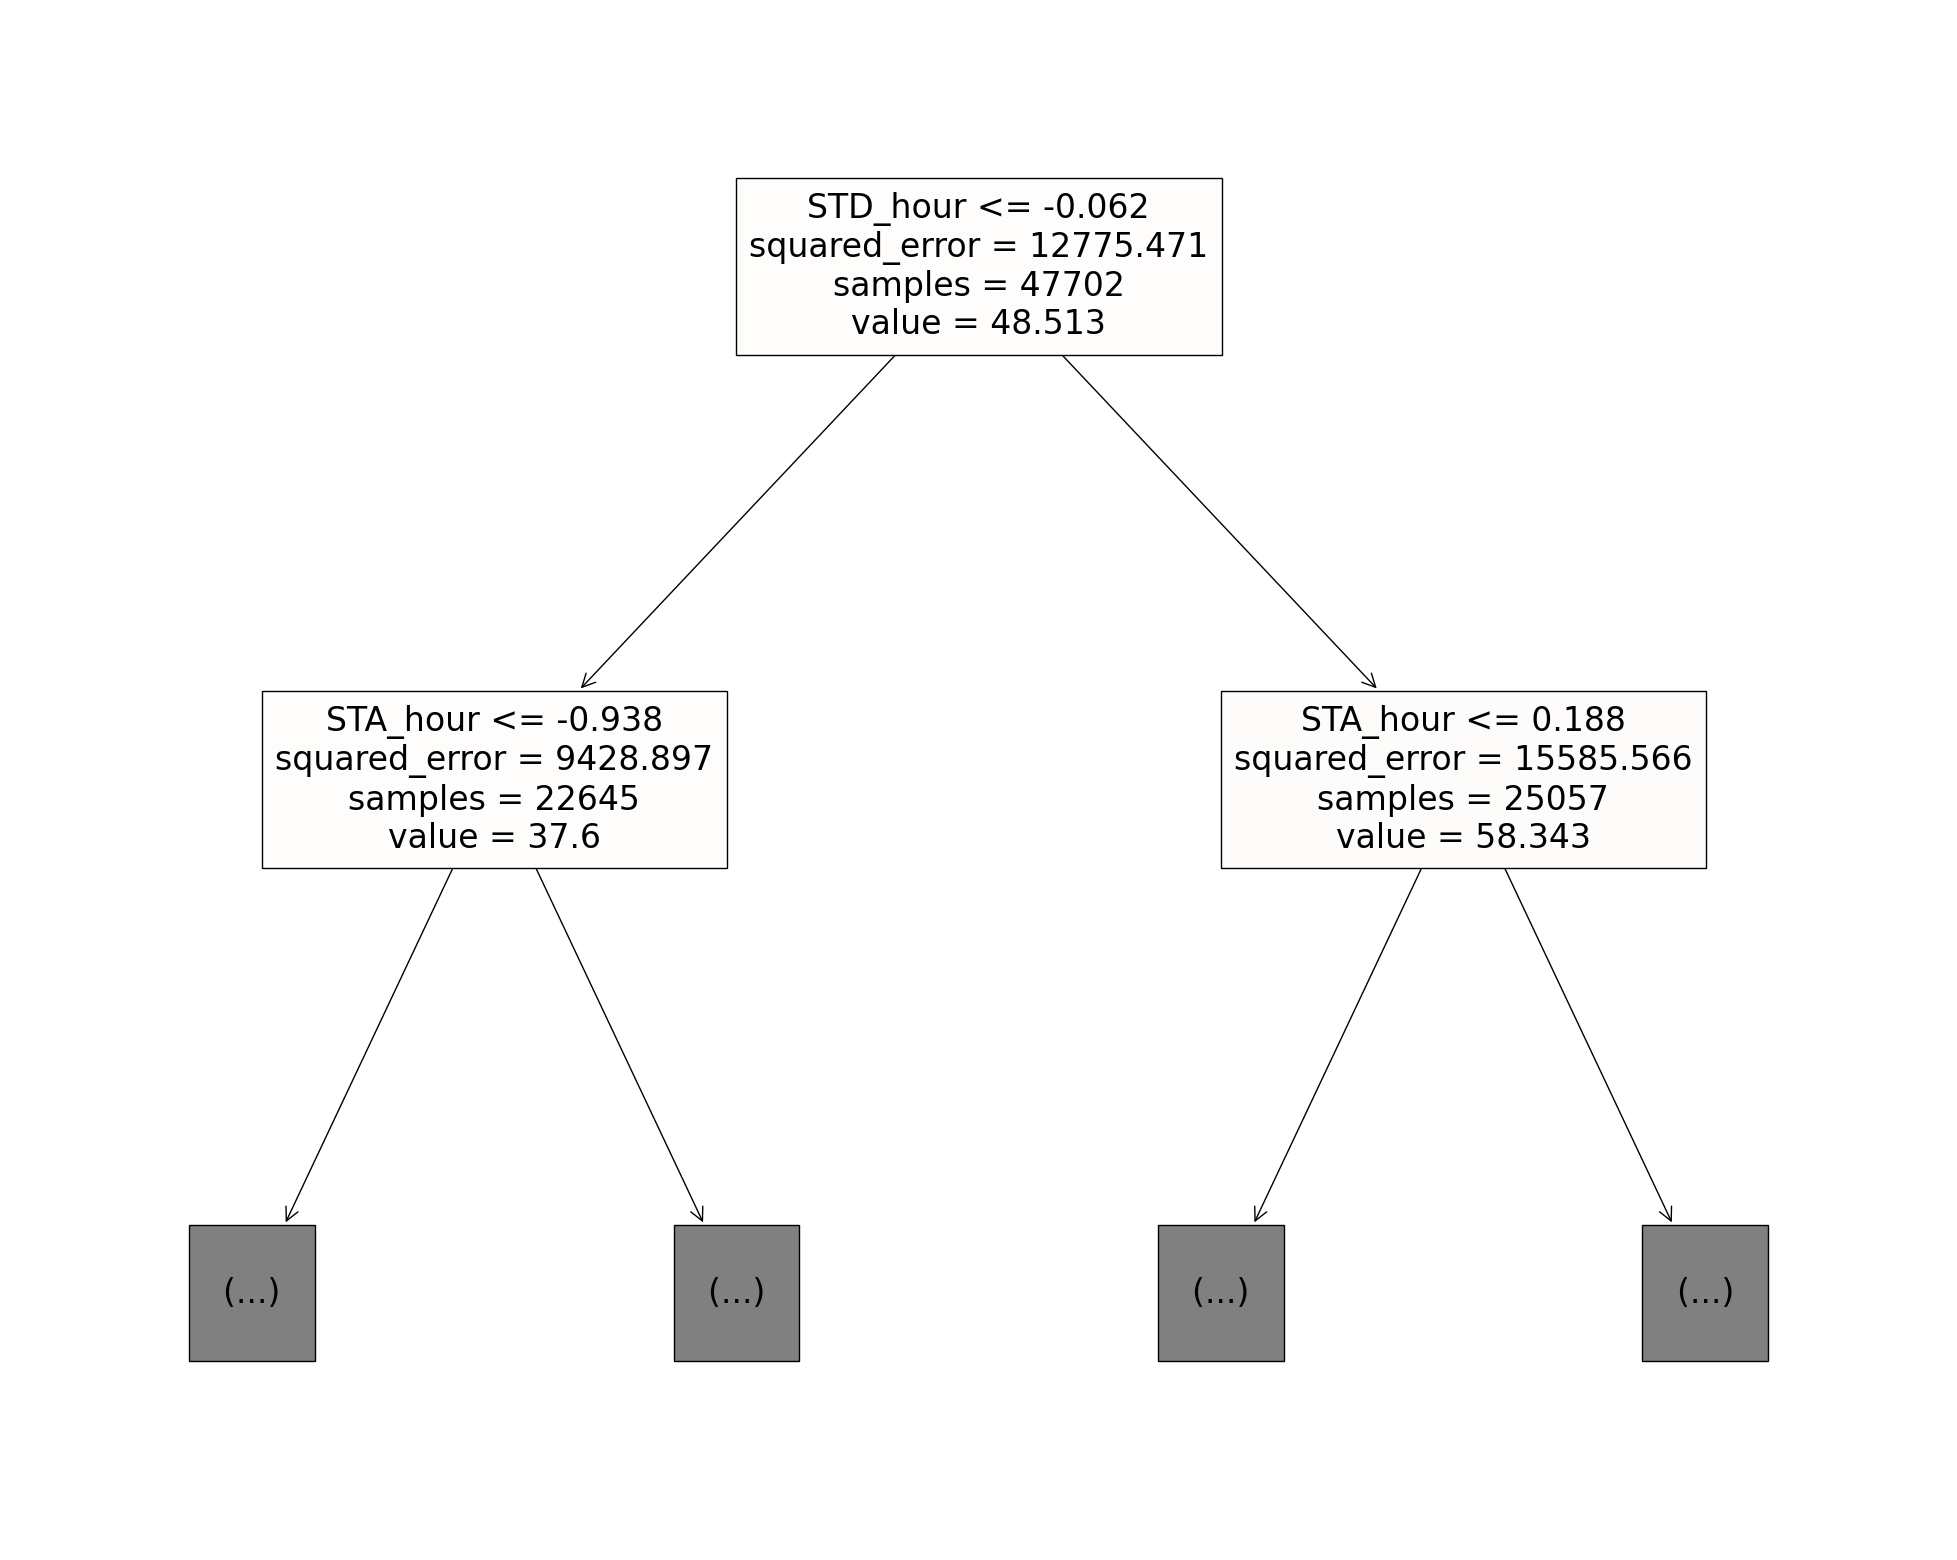

In [342]:
# Extract the first decision tree from the RandomForestRegressor
first_tree = model_dtc.estimators_[0]

# Plot the first decision tree
fig = plt.figure(figsize=(25, 20))
dectree_plot = plot_tree(first_tree, max_depth=1, filled=True, feature_names=features)

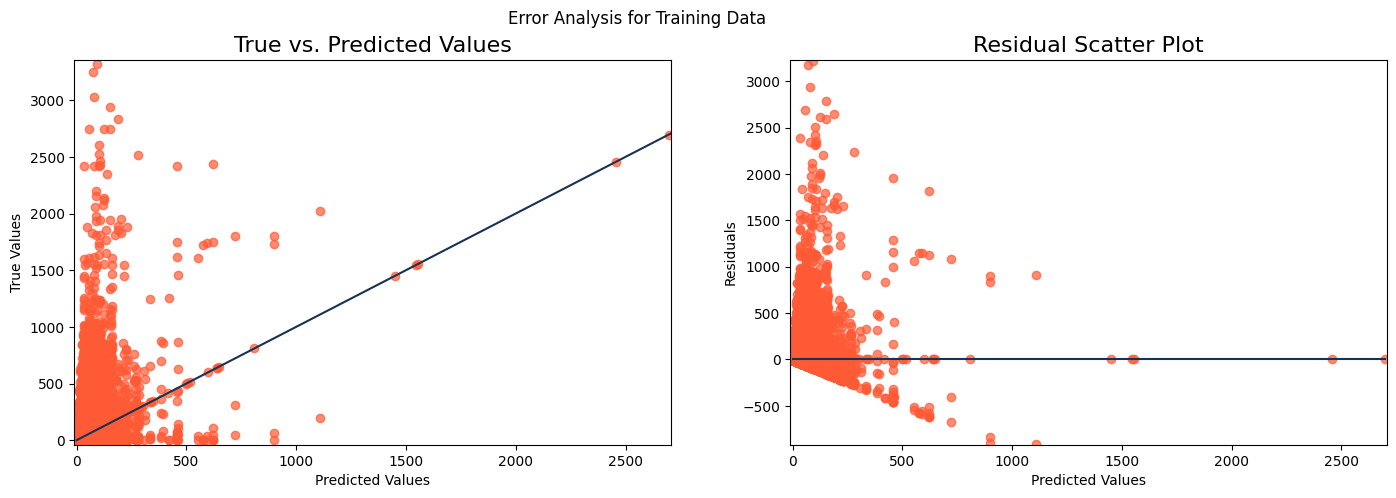

In [273]:
# Calculate residuals
residuals_train = y_train - pred_train_dtc

# Plot true vs. predicted values and residuals
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(right=1)
plt.suptitle('Error Analysis for Training Data')

# True vs. predicted values
ax[0].scatter(pred_train_dtc, y_train, color="#FF5A36", alpha=0.7)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="#193251")
ax[0].set_title("True vs. Predicted Values", fontsize=16)
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("True Values")
ax[0].set_xlim((pred_train_dtc.min() - 10), (pred_train_dtc.max() + 10))
ax[0].set_ylim((y_train.min() - 40), (y_train.max() + 40))

# Residual scatter plot
ax[1].scatter(pred_train_dtc, residuals_train, color="#FF5A36", alpha=0.7)
ax[1].plot([pred_train_dtc.min(), pred_train_dtc.max()], [0, 0], color="#193251")
ax[1].set_title("Residual Scatter Plot", fontsize=16)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residuals")
ax[1].set_xlim((pred_train_dtc.min() - 10), (pred_train_dtc.max() + 10))
ax[1].set_ylim((residuals_train.min() - 10), (residuals_train.max() + 10))

plt.show()